In [1]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla K80


In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import re
from tqdm import tqdm_notebook

from nltk.corpus import stopwords

from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [3]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 100 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100
GLOVE_DIR = r"glove.twitter.27B.100d.txt"

In [4]:
import os 
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/DATASET AML/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Glove

In [5]:
embeddings_index = {}
f = open(GLOVE_DIR, encoding="utf8")
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")


Loading GloVe from: glove.twitter.27B.100d.txt ...Done.
 Proceeding with Embedding Matrix...

Mounted at /content/drive


#Import Dataset

EDA BINARY

In [6]:
os.chdir('/content/drive/My Drive/DATASET AML/PROJECT/dataset_giusti')

In [7]:
train = pd.read_csv("BINARY_augmented_EDA_undersampling_senza_stopword_FINAL.csv")
train["comment_text"] = train["comment_text"].astype(str)
train.head()

,comment_text,bad
0,comrade soviet hell,1
1,nope not read guide appeal not time user quest...,0
2,would like help think block fatuorum,0
3,mosslash wpsubpage article,0
4,yeah administrate like shit anyway close user ...,1


#Tokenization and Embedding

In [32]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train['comment_text'].values)
sequences = tokenizer.texts_to_sequences(train["comment_text"])
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 72620


In [10]:
embeddings_dict = {}

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_dict[word] = embedding_vector
print(" Completed!")

 Completed!


In [11]:
tsne = TSNE(n_components=2, random_state=0)
words =  list(embeddings_dict.keys())
vectors = [embeddings_dict[word] for word in words]

In [12]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

In [13]:
labels = ['bad']
y = to_categorical(train[labels].values)

In [14]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (46362, 100)
Shape of label tensor: (46362, 2)


In [15]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

In [16]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [18518. 18572.]
validation:  [4663. 4609.]


In [17]:
print('Tokenized sentences: \n', data[20])
print('One hot label: \n', labels[20])

Tokenized sentences: 
 [999 323  80 810   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
One hot label: 
 [1. 0.]


In [18]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

 Completed!


#LSTM MODEL

In [19]:
from tensorflow.keras.layers import Bidirectional

In [61]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)
x = (Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer')))(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(2, activation="sigmoid")(x)

In [62]:
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])

In [63]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 4, batch_size=128, validation_data=(x_val, y_val), verbose = 2)

Training progress:
Epoch 1/4
290/290 - 81s - loss: 0.2875 - accuracy: 0.8766 - val_loss: 0.2024 - val_accuracy: 0.9163
Epoch 2/4
290/290 - 76s - loss: 0.2061 - accuracy: 0.9158 - val_loss: 0.1915 - val_accuracy: 0.9223
Epoch 3/4
290/290 - 77s - loss: 0.1916 - accuracy: 0.9235 - val_loss: 0.1827 - val_accuracy: 0.9237
Epoch 4/4
290/290 - 76s - loss: 0.1770 - accuracy: 0.9289 - val_loss: 0.1910 - val_accuracy: 0.9221


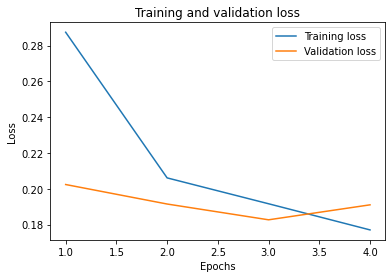

In [64]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

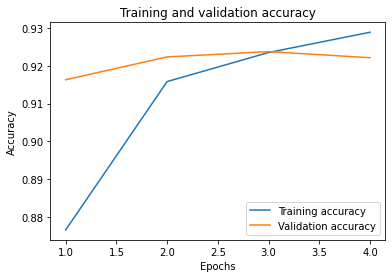

In [65]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

# Test

In [25]:
os.chdir('/content/drive/My Drive/DATASET AML/PROJECT/dataset_giusti/TEST')

In [66]:
test = pd.read_csv("test_binary_senza_stopword.csv")

In [67]:
test

,Unnamed: 0,Unnamed: 0.1,comment_text,bad
0,0,5,thank you for understand i think very highly o...,0
1,1,7,dear god this site be horrible,0
2,2,11,somebody will invariably try to add religion r...,0
3,3,13,it say it right there that it be a type the ty...,0
4,4,14,before add a new product to the list make sure...,0
...,...,...,...,...
63973,63973,153150,jerome i see you never get around to this im n...,0
63974,63974,153151,lucky bastard httpwikimediafoundationorgwikipr...,0
63975,63975,153154,shame on you all you want to speak about gay a...,0
63976,63976,153155,mel gibson be a nazi bitch who make shitty mov...,1


In [68]:

sequences = tokenizer.texts_to_sequences(test["comment_text"].astype(str))


In [69]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

In [70]:
labels = ['bad']
y = to_categorical(test[labels].values)

In [71]:
eval= model.evaluate(data,y)

2000/2000 [==============================] - 53s 26ms/step - loss: 0.3643 - accuracy: 0.8700


In [72]:
performance = model.predict(data)


In [43]:
import sklearn

In [73]:
y_pred =np.round(performance)

In [77]:
sklearn.metrics.recall_score(y, y_pred, average= 'macro')

0.8954397436430439

In [36]:
print(" TEST LOSS: ", performance[0])

 TEST LOSS:  [0.9870694  0.01264051]
